# AutoInland Vehicle Insurance Claim Challenge StarterNotebook - Python

This is a simple starter notebook to get started with the AutoInland Vehicle Insurance Claim Challenge on Zindi.

This notebook covers:
- Loading the data
- Simple EDA and an example of feature enginnering
- Data preprocessing and data wrangling
- Creating a simple model
- Making a submission
- Some tips for improving your score

**Mount drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
root_path = '/content/drive/MyDrive/ColabNotebooks/zindi/autoInland/'

### Importing libraries

In [32]:
import pandas as pd
import numpy as np
import datetime as dt
from tqdm.notebook import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report

### Read files

In [6]:

# Load files into a pandas dataframe
train = pd.read_csv(root_path + 'Train.csv')
test = pd.read_csv(root_path + 'Test.csv')
ss = pd.read_csv(root_path + 'SampleSubmission.csv')

### Some basic EDA

In [7]:
# Preview the first five rows of the train set
train.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,NaN,NaN,Car Classic,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,NaN,NaN,Car Classic,1
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,NaN,NaN,Car Classic,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,NaN,NaN,CarSafe,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,Lagos,Lagos,Muuve,1


In [8]:
# Preview the first five rows of the test set
test.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName
0,ID_01QM0NU,2010-10-23,2011-10-22,Female,46,2010-10-23,1,NaN,NaN,Ford,Abuja Municipal,Abuja-Municipal,Car Classic
1,ID_024NJLZ,2010-10-14,2011-10-13,Male,32,2010-10-14,1,NaN,NaN,NaN,Kosofe,Benue,Car Classic
2,ID_02NOVWQ,2010-08-29,2011-08-28,Female,45,2010-08-29,2,Saloon,Black,Honda,Wuse 11,Abuja,Car Classic
3,ID_02VSP68,2010-06-13,2011-06-12,Female,58,2010-06-13,1,Saloon,NaN,TOYOTA,NaN,NaN,CarSafe
4,ID_02YB37K,2010-07-01,2011-06-30,NaN,120,2010-07-01,1,Saloon,Red,Hyundai,Victoria Island,Lagos,Car Classic


In [9]:
# Preview the first five rows of the sample submission file
ss.head()

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [10]:
# Check the shape of the train and test sets
print(f'The shape of the train set is: {train.shape}\nThe shape of the test set is: {test.shape}')

The shape of the train set is: (12079, 14)
The shape of the test set is: (1202, 13)


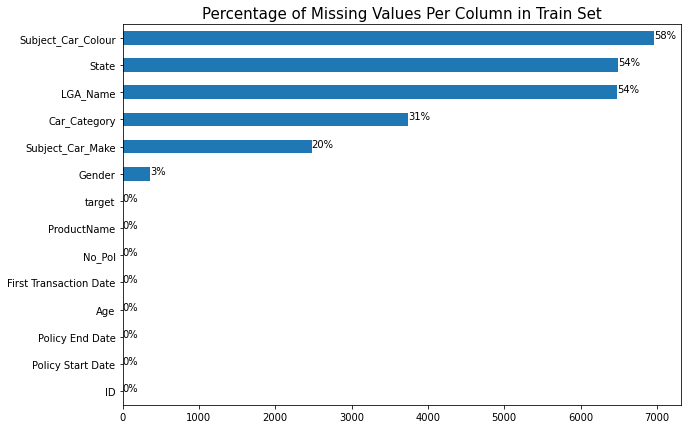

In [11]:
# Check if there any missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

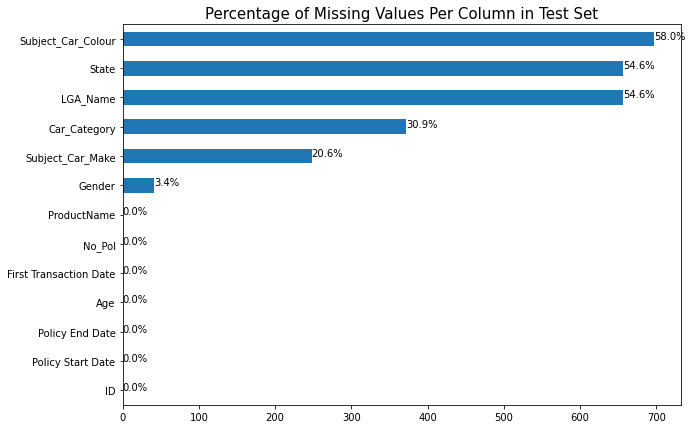

In [12]:
# Check if there missing values in test set
ax = test.isna().sum().sort_values().plot(kind = 'barh', figsize = (10, 7))
plt.title('Percentage of Missing Values Per Column in Test Set', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.1f}%'.format((p.get_width()/test.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

## Combine train and test set for easy preprocessing 

In [13]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (13281, 14)


In [14]:
# Preview the last five rows of the combined dataframe
all_data.tail()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target
13276,ID_ZTTHC5X,2010-12-05,2011-12-04,Male,67,2010-12-05,2,JEEP,Black,TOYOTA,Victoria Island,Lagos,Car Classic,NaN
13277,ID_ZUJAFUP,2010-01-14,2011-01-13,Male,43,2010-01-14,1,Saloon,Silver,Hyundai,Surulere,Lagos,Car Classic,NaN
13278,ID_ZWHCTUM,2010-07-26,2011-07-25,Male,30,2010-07-26,1,Truck,White,Iveco,Victoria Island,Lagos,CVTP,NaN
13279,ID_ZWQRL8L,2010-02-16,2011-02-15,Male,44,2010-02-16,2,Saloon,NaN,Nissan,Aba North,Aba-North,Car Classic,NaN
13280,ID_ZWZ92GU,2010-03-18,2011-03-17,Male,28,2010-03-18,1,Saloon,Silver,TOYOTA,NaN,NaN,Car Classic,NaN


In [15]:
# Check the column names and datatypes
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      13281 non-null  object 
 1   Policy Start Date       13281 non-null  object 
 2   Policy End Date         13281 non-null  object 
 3   Gender                  12881 non-null  object 
 4   Age                     13281 non-null  int64  
 5   First Transaction Date  13281 non-null  object 
 6   No_Pol                  13281 non-null  int64  
 7   Car_Category            9171 non-null   object 
 8   Subject_Car_Colour      5622 non-null   object 
 9   Subject_Car_Make        10557 non-null  object 
 10  LGA_Name                6149 non-null   object 
 11  State                   6137 non-null   object 
 12  ProductName             13281 non-null  object 
 13  target                  12079 non-null  float64
dtypes: float64(1), int64(2), object(11)
me

In [16]:
# Change each column to its appriopriate datatype
date_cols = [col for col in all_data.columns if 'Date' in col]
num_cols = ['Age', 'No_Pol']
cat_cols = [col for col in all_data.columns if col not in date_cols+num_cols+['ID', 'target']]

for col in all_data.columns:
  if col in date_cols:
    all_data[col] = pd.to_datetime(all_data[col])
  elif col in cat_cols:
    all_data[col] = all_data[col].astype('category')

# Confirm whether the changes have been applied successfully
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13281 entries, 0 to 13280
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   ID                      13281 non-null  object        
 1   Policy Start Date       13281 non-null  datetime64[ns]
 2   Policy End Date         13281 non-null  datetime64[ns]
 3   Gender                  12881 non-null  category      
 4   Age                     13281 non-null  int64         
 5   First Transaction Date  13281 non-null  datetime64[ns]
 6   No_Pol                  13281 non-null  int64         
 7   Car_Category            9171 non-null   category      
 8   Subject_Car_Colour      5622 non-null   category      
 9   Subject_Car_Make        10557 non-null  category      
 10  LGA_Name                6149 non-null   category      
 11  State                   6137 non-null   category      
 12  ProductName             13281 non-null  catego

### Distribution of the target variable

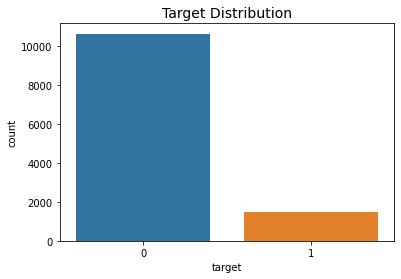

In [17]:
sns.countplot(train.target)
plt.title('Target Distribution', fontdict={'size':14});

### Distribution of the Gender column

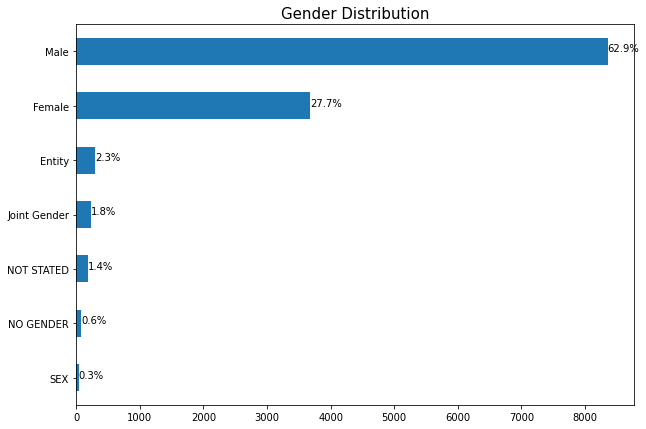

In [18]:
# Gender distribution 
ax = all_data.Gender.value_counts().sort_values().plot(kind = 'barh', figsize=(10,7))
plt.title('Gender Distribution', fontdict={'size': 15})
for p in ax.patches:
  percentage ='{:,.1f}%'.format((p.get_width()/all_data.shape[0])*100)
  width, height =p.get_width(),p.get_height()
  x=p.get_x()+width+0.02
  y=p.get_y()+height/2
  ax.annotate(percentage,(x,y))

In [19]:
mapper = {'Entity':'Other', 'Joint Gender':'Other', 'NOT STATED':'Other', 'NO GENDER': 'Other', 'SEX':"Other"}
all_data.Gender = all_data.Gender.replace(mapper)

# Confirm mappings
all_data.Gender.value_counts()

Male      8356
Female    3679
Other      846
Name: Gender, dtype: int64

### Number of unique values per categorical column

In [20]:
# Check unique values for each categorical column
for col in cat_cols:
  print(col)
  print(all_data[col].unique(), '\n')

Gender
['Male' 'Female' 'Other' nan] 

Car_Category
['Saloon', 'JEEP', NaN, 'Motorcycle', 'Truck', ..., 'Wagon', 'Shape Of Vehicle Chasis', 'Sedan', 'Station 4 Wheel', 'Tipper Truck']
Length: 17
Categories (16, object): ['Saloon', 'JEEP', 'Motorcycle', 'Truck', ..., 'Shape Of Vehicle Chasis',
                          'Sedan', 'Station 4 Wheel', 'Tipper Truck'] 

Subject_Car_Colour
['Black', 'Grey', 'Red', NaN, 'As Attached', ..., 'Yellow & White', 'Beige Mitalic', 'Light Gray', 'Blue Sky', 'Red Maroon']
Length: 47
Categories (46, object): ['Black', 'Grey', 'Red', 'As Attached', ..., 'Beige Mitalic',
                          'Light Gray', 'Blue Sky', 'Red Maroon'] 

Subject_Car_Make
['TOYOTA', NaN, 'REXTON', 'Lexus', 'Hyundai', ..., 'BRILLIANCE', 'Buik', 'COMMANDER', 'Bajaj', 'Datsun']
Length: 76
Categories (75, object): ['TOYOTA', 'REXTON', 'Lexus', 'Hyundai', ..., 'Buik', 'COMMANDER', 'Bajaj',
                          'Datsun'] 

LGA_Name
[NaN, 'Lagos', 'Ikeja', 'Badagry', 'Eti-Osa

### Filling in missing values
#### Missing values can be filled using different strategies
Tips:
 - Mean
 - Max
 - Min
 - [sklearn SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
 - Others... do more reasearch

In [21]:
# Fill in missing values
# For cat cols and date cols fill in with mode and for num cols fill in with 9999
for col in all_data.columns:
  if col in date_cols+cat_cols:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
  elif col in num_cols:
    all_data[col] = all_data[col].fillna(all_data[col].fillna(9999))

# Confirm that there aren't any missing values
all_data[all_data.columns.difference(['target'])].isna().sum()

Age                       0
Car_Category              0
First Transaction Date    0
Gender                    0
ID                        0
LGA_Name                  0
No_Pol                    0
Policy End Date           0
Policy Start Date         0
ProductName               0
State                     0
Subject_Car_Colour        0
Subject_Car_Make          0
dtype: int64

### Feature Engineering
#### Alot of features can be extracted from dates
Tips:
 - Quarter, Start of Year, month?
 - Is it a weekend, weekday?
 - Is it a holiday
 - Duration between different periods, e.g start and end of a policy
 - What features can be derived from the age column
 - Be creative 😉

In [22]:
# Extract date features from the date columns
for col in date_cols:
  for date_feature in ['year', 'month', 'day']:
    all_data[col+date_feature] = getattr(all_data[col].dt, date_feature)

all_data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,LGA_Name,State,ProductName,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,5,14,2011,5,13,2010,5,14
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,Victoria Island,Lagos,Car Classic,1.0,2010,11,29,2011,11,28,2010,11,29
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,Victoria Island,Lagos,Car Classic,0.0,2010,3,21,2011,3,20,2010,3,21
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,Saloon,Black,TOYOTA,Victoria Island,Lagos,CarSafe,0.0,2010,8,21,2011,8,20,2010,8,21
4,ID_00BRP63,2010-08-29,2010-12-31,Other,20,2010-08-29,3,Saloon,Black,TOYOTA,Lagos,Lagos,Muuve,1.0,2010,8,29,2010,12,31,2010,8,29


#### Try different strategies of dealing with categorical variables
Tips:
 - One hot encoding
 - Label encoding
 - Target encoding
 - Reduce the number of unique values...

In [23]:
# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,ID,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,target,Policy Start Dateyear,Policy Start Datemonth,Policy Start Dateday,Policy End Dateyear,Policy End Datemonth,Policy End Dateday,First Transaction Dateyear,First Transaction Datemonth,First Transaction Dateday,Gender_Female,Gender_Male,Gender_Other,Car_Category_Bus,Car_Category_CAMRY CAR HIRE,Car_Category_JEEP,Car_Category_Mini Bus,Car_Category_Mini Van,Car_Category_Motorcycle,Car_Category_Pick Up,Car_Category_Pick Up > 3 Tons,Car_Category_Saloon,Car_Category_Sedan,Car_Category_Shape Of Vehicle Chasis,Car_Category_Station 4 Wheel,Car_Category_Tipper Truck,Car_Category_Truck,Car_Category_Van,Car_Category_Wagon,Subject_Car_Colour_As Attached,Subject_Car_Colour_Ash,Subject_Car_Colour_B.Silver,Subject_Car_Colour_Beige Mitalic,Subject_Car_Colour_Black,...,State_Nsit-Ubium,State_Obafemi-Owode,State_Obia-Akpor,State_Ogba-Ndoni,State_Ogbmosho-South,State_Ogun,State_Ogun-Waterside,State_Ondo,State_Ondo-West,State_Onitsha-North,State_Onitsha-South,State_Orile-Iganmu,State_Oshimili-North,State_Oshodi-Isolo,State_Osun,State_Ovia-SouthWest,State_Owerri-Municipal,State_Owerri-North,State_Owerri-West,State_Oyo,State_Oyo-East,State_Oyo-West,State_Port-Harcourt,State_QuaAn-Pan,State_Rivers,State_Udi-Agwu,State_Ughelli-North,State_Umuahia-South,State_Warri-Central,State_Warri-North,State_Warri-South,ProductName_CVTP,ProductName_Car Classic,ProductName_Car Plus,ProductName_Car Vintage,ProductName_CarFlex,ProductName_CarSafe,ProductName_Customized Motor,ProductName_Motor Cycle,ProductName_Muuve
0,ID_0040R73,2010-05-14,2011-05-13,30,2010-05-14,1,0.0,2010,5,14,2011,5,13,2010,5,14,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,ID_0046BNK,2010-11-29,2011-11-28,79,2010-11-29,1,1.0,2010,11,29,2011,11,28,2010,11,29,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,ID_005QMC3,2010-03-21,2011-03-20,43,2010-03-21,1,0.0,2010,3,21,2011,3,20,2010,3,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,ID_0079OHW,2010-08-21,2011-08-20,2,2010-08-21,1,0.0,2010,8,21,2011,8,20,2010,8,21,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,ID_00BRP63,2010-08-29,2010-12-31,20,2010-08-29,3,1.0,2010,8,29,2010,12,31,2010,8,29,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [24]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

# Check the shapes of the split dataset
train_df.shape, test_df.shape

((12079, 548), (1202, 548))

### Training and making predictions
Tips:
- Is lgbm the best model for this challenge?
- Parameter tuning
 - Grid search, random search, perhaps bayesian search works better...



In [34]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import auc, classification_report, roc_auc_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

from lightgbm import LGBMClassifier

from copy import deepcopy

import xgboost
from xgboost import XGBClassifier

import lightgbm
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

from numba import jit, cuda

from sklearn.datasets import load_iris


In [35]:
models = [
    ('Decision Tree', DecisionTreeClassifier(max_depth=5)),
    ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=250, max_features=1)),
    ('AdaBoost', AdaBoostClassifier()),
    ('KNN', KNeighborsClassifier(n_neighbors=3)),
    ('MLP - neural network', MLPClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Logistic Regression', LogisticRegression()),
    ('Support Vector Machines', SVC(gamma=2, C=1)),
    ('Linear SVC', LinearSVC()),
    ('Stochastic Gradient Descent (SGD)', SGDClassifier()),
    ('LightGBM Classifier', LGBMClassifier(objective='multiclass', random_state=5)),
    ('Gradient Boost Classifier', GradientBoostingClassifier()),
    ('XGBClassifier', XGBClassifier()),
    ('LGBMClassifier', LGBMClassifier()),
    ('OneVsRestClassifier', OneVsRestClassifier(LinearSVC(random_state=0))),
    ('SGDClassifier', SGDClassifier(loss="hinge", penalty="l2", max_iter=5)),
    ('SVC', SVC(kernel='linear', C=1))
]

In [46]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(date_cols+['ID', 'target'])
X = train_df[main_cols]
y = train_df.target

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

# Train model
#model = LGBMClassifier()
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)


# Make predictions
y_pred = model.predict(X_test)

# Check the f1 score of the model
print(f'F1 score on the X_test is: {f1_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

F1 score on the X_test is: 0.23753665689149558
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      3184
         1.0       0.33      0.18      0.24       440

    accuracy                           0.86      3624
   macro avg       0.61      0.57      0.58      3624
weighted avg       0.83      0.86      0.84      3624



#### [More on F1 Score](https://en.wikipedia.org/wiki/F-score)

### Making predictions of the test set and creating a submission file

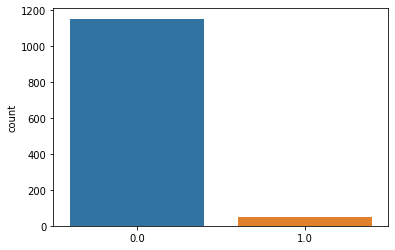

In [47]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df)

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [48]:
# Create a csv file and upload to zindi 
sub_file.to_csv(root_path + 'AutoInlandSub.csv', index = False)

###More Tips
- Thorough EDA and domain knowledge sourcing
- Re-group Categorical features 
- More Feature Engineering 
- Dataset balancing - oversampling, undersampling, SMOTE...
- Ensembling of models 
- Cross-validation: Group folds, Stratified...

# ******************* GOOD LUCK!!! ***************************